In [26]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style="whitegrid")

BASE_DIR = Path("..")
PROCESSED_DIR = BASE_DIR / "processed"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

print("📁 Procesados:", PROCESSED_DIR.resolve())
print("📁 Modelos:   ", MODELS_DIR.resolve())

📁 Procesados: D:\ICD-SOIL\processed
📁 Modelos:    D:\ICD-SOIL\models


In [27]:

data_path = PROCESSED_DIR / "suelos_anomalias.csv"

if not data_path.exists():
    raise FileNotFoundError("❌ No se encuentra 'suelos_anomalias.csv'. Ejecuta antes el libro 03.")

df = pd.read_csv(data_path)
print("Dataset cargado:", df.shape)
df.head()

Dataset cargado: (35111, 44)


C:\Users\diego\AppData\Local\Temp\ipykernel_17528\2530590821.py:6: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,secuencial,fecha_de_an_lisis,departamento,municipio,cultivo,estado,tiempo_de_establecimiento,topografia,drenaje,riego,...,hierro_olsen,manganeso_olsen,zinc_olsen,hierro_doble_acido,manganeso_doble_acido,zinc_doble_acido,iso_score,lof_score,anom_score_global,is_outlier
0,1,2014-07-01,NARIÑO,SAN ANDRÉS DE TUMACO,No Indica,No indica,No indica,No indica,No indica,No indica,...,66.39,1.700,1.500,NaN,NaN,NaN,0.040404,0.0,0.020202,0
1,164,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Plano,Buen drenaje,Aspersión,...,222.00,3.599,2.500,NaN,NaN,NaN,0.040200,0.0,0.020100,0
2,165,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Ondulado,Buen drenaje,Aspersión,...,345.00,3.900,7.000,NaN,NaN,NaN,0.182721,0.0,0.091361,1
3,166,2014-05-09,CUNDINAMARCA,FUNZA,Guisantes,Por establecer,No indica,Plano,Buen drenaje,Goteo,...,102.00,3.599,7.500,NaN,NaN,NaN,0.096554,0.0,0.048277,0
4,167,2014-05-09,VALLE DEL CAUCA,LA UNIÓN,Guanábana,Establecido,Mas de 10 años,Plano,Buen drenaje,Manguera,...,8.10,0.800,1.799,NaN,NaN,NaN,0.331227,0.0,0.165614,1


In [28]:
VARIABLES_SUELO = [
    "ph_agua_suelo", "materia_organica", "fosforo_bray_ii",
    "azufre_fosfato_monocalcico", "acidez_intercambiable",
    "aluminio_intercambiable", "calcio_intercambiable",
    "magnesio_intercambiable", "potasio_intercambiable",
    "sodio_intercambiable", "cic", "conductividad_electrica",
    "hierro_olsen", "cobre_disponible", "manganeso_olsen",
    "zinc_olsen", "boro_disponible",
    "hierro_doble_acido", "cobre_disponible_doble_acido",
    "manganeso_doble_acido", "zinc_doble_acido"
]

vars_present = [v for v in VARIABLES_SUELO if v in df.columns]
print(f"Variables de suelo encontradas en el dataset ({len(vars_present)}):")
print(vars_present)

Variables de suelo encontradas en el dataset (21):
['ph_agua_suelo', 'materia_organica', 'fosforo_bray_ii', 'azufre_fosfato_monocalcico', 'acidez_intercambiable', 'aluminio_intercambiable', 'calcio_intercambiable', 'magnesio_intercambiable', 'potasio_intercambiable', 'sodio_intercambiable', 'cic', 'conductividad_electrica', 'hierro_olsen', 'cobre_disponible', 'manganeso_olsen', 'zinc_olsen', 'boro_disponible', 'hierro_doble_acido', 'cobre_disponible_doble_acido', 'manganeso_doble_acido', 'zinc_doble_acido']


In [29]:
# Umbral mínimo de filas con dato real para entrenar modelo
MIN_MUESTRAS_TARGET = 500   # puedes ajustar

# Variables objetivo a modelar (usar todas las presentes)
TARGET_VARS = vars_present.copy()

print(f"Variables objetivo (TARGET_VARS) = {len(TARGET_VARS)}")
TARGET_VARS

Variables objetivo (TARGET_VARS) = 21


['ph_agua_suelo',
 'materia_organica',
 'fosforo_bray_ii',
 'azufre_fosfato_monocalcico',
 'acidez_intercambiable',
 'aluminio_intercambiable',
 'calcio_intercambiable',
 'magnesio_intercambiable',
 'potasio_intercambiable',
 'sodio_intercambiable',
 'cic',
 'conductividad_electrica',
 'hierro_olsen',
 'cobre_disponible',
 'manganeso_olsen',
 'zinc_olsen',
 'boro_disponible',
 'hierro_doble_acido',
 'cobre_disponible_doble_acido',
 'manganeso_doble_acido',
 'zinc_doble_acido']

In [30]:
def entrenar_modelo_y_icd(df, target_var, feature_vars,
                          min_muestras=MIN_MUESTRAS_TARGET,
                          random_state=42):
    """
    Entrena un modelo de regresión para 'target_var' usando 'feature_vars'
    y genera una serie 'icd_predictivo_target_var' en [0,1] a partir del error
    absoluto normalizado.

    Devuelve:
      - pipe (Pipeline entrenado)
      - metrics (dict con MAE, RMSE, R2, n_muestras)
      - icd_series (pd.Series indexada como df[target_var])
    """

    # 1) Filtrar filas con dato real en y
    y = df[target_var]
    X = df[feature_vars]

    mask = y.notna()
    y = y[mask]
    X = X[mask]

    n = len(y)
    if n < min_muestras:
        print(f"⚠ Muy pocas muestras válidas para {target_var} ({n} < {min_muestras}). Se omite.")
        return None, None, None

    # 2) Quitar columnas completamente vacías entre las features
    valid_features = [f for f in feature_vars if X[f].notna().sum() > 0]

    if len(valid_features) < 2:
        print(f"⚠ Muy pocas variables útiles para predecir {target_var}. Se omite.")
        return None, None, None

    X = X[valid_features]

    # 3) Definir pipeline de ML
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    # 4) Train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=random_state
    )

    # 5) Entrenar modelo
    pipe.fit(X_train, y_train)

    # 6) Evaluar en test
    y_pred_test = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "n_muestras": int(n)
    }

    # 7) Generar predicciones en TODO el dataset donde target_var no es NaN
    y_pred_full = pipe.predict(X)

    # 8) Construir ICD predictivo por registro (0–1, 1 = perfecta coherencia)
    abs_error = np.abs(y - y_pred_full)

    # Escala de normalización: factor*K*desviación estándar del target
    std_y = y.std()
    if std_y == 0 or np.isnan(std_y):
        denom = abs_error.max() if abs_error.max() > 0 else 1.0
    else:
        denom = 3 * std_y  # tres desviaciones estándar ~ límite razonable

    icd_values = 1 - np.minimum(abs_error / denom, 1.0)
    icd_values = icd_values.clip(0, 1)

    icd_series = pd.Series(icd_values, index=y.index,
                           name=f"icd_predictivo_{target_var}")

    return pipe, metrics, icd_series

In [34]:
modelos = {}
metricas = []
icd_columns = []

for target in TARGET_VARS:
    print(f"\n🔍 Entrenando modelo para variable objetivo: {target}")

    # Features = todas las demás variables de suelo presentes
    feature_vars = [v for v in vars_present if v != target]

    if len(feature_vars) == 0:
        print(f"⚠ No hay variables predictoras para {target}. Se omite.")
        continue

    pipe, metrics, icd_series = entrenar_modelo_y_icd(df, target, feature_vars)

    if pipe is None:
        continue

    modelos[target] = pipe
    metricas.append({
        "variable": target,
        **metrics
    })

    # Añadir columna ICD predictivo al dataframe original
    col_name = icd_series.name
    df[col_name] = icd_series
    icd_columns.append(col_name)

    print(f"  → MAE  = {metrics['MAE']:.4f}")
    print(f"  → RMSE = {metrics['RMSE']:.4f}")
    print(f"  → R2   = {metrics['R2']:.4f}")


🔍 Entrenando modelo para variable objetivo: ph_agua_suelo
  → MAE  = 0.2063
  → RMSE = 0.2993
  → R2   = 0.9140

🔍 Entrenando modelo para variable objetivo: materia_organica
  → MAE  = 1.7436
  → RMSE = 2.9151
  → R2   = 0.5303

🔍 Entrenando modelo para variable objetivo: fosforo_bray_ii
  → MAE  = 22.9161
  → RMSE = 56.3009
  → R2   = 0.4383

🔍 Entrenando modelo para variable objetivo: azufre_fosfato_monocalcico
  → MAE  = 7.7131
  → RMSE = 42.1781
  → R2   = 0.5284

🔍 Entrenando modelo para variable objetivo: acidez_intercambiable
  → MAE  = 0.1587
  → RMSE = 0.2908
  → R2   = 0.9809

🔍 Entrenando modelo para variable objetivo: aluminio_intercambiable
  → MAE  = 0.1436
  → RMSE = 0.2688
  → R2   = 0.9780

🔍 Entrenando modelo para variable objetivo: calcio_intercambiable
  → MAE  = 0.3103
  → RMSE = 1.3259
  → R2   = 0.9785

🔍 Entrenando modelo para variable objetivo: magnesio_intercambiable
  → MAE  = 0.2695
  → RMSE = 0.6677
  → R2   = 0.9388

🔍 Entrenando modelo para variable obje

In [39]:
if metricas:
    df_metricas = pd.DataFrame(metricas).sort_values("R2", ascending=False)
    df_metricas
else:
    print("⚠ No se entrenó ningún modelo.")

📌 Ejemplo de análisis visual para: cic


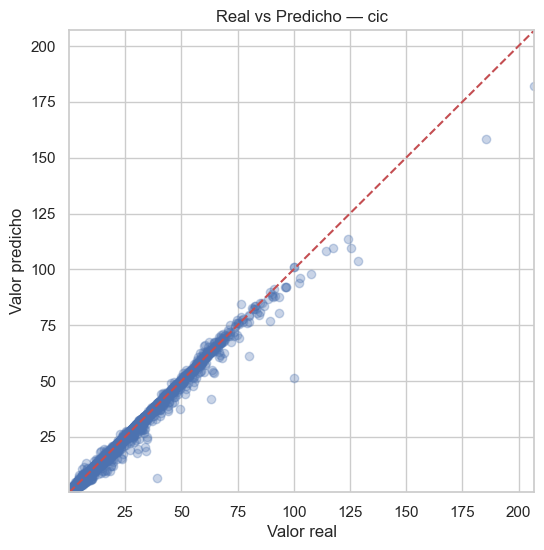

In [40]:
# Elegir una variable con buen R2 para visualizar
if metricas:
    mejor = max(metricas, key=lambda x: x["R2"])
    var_plot = mejor["variable"]
    print("📌 Ejemplo de análisis visual para:", var_plot)

    # Reconstruir X e y para la variable elegida
    feature_vars = [v for v in vars_present if v != var_plot]
    mask = df[var_plot].notna()
    X_vis = df.loc[mask, feature_vars]
    y_vis = df.loc[mask, var_plot]

    # Filtrar features válidas (como en la función)
    valid_features = [f for f in feature_vars if X_vis[f].notna().sum() > 0]
    X_vis = X_vis[valid_features]

    model_vis = modelos[var_plot]
    y_pred_vis = model_vis.predict(X_vis)

    plt.figure(figsize=(6,6))
    plt.scatter(y_vis, y_pred_vis, alpha=0.3)
    lims = [
        min(y_vis.min(), y_pred_vis.min()),
        max(y_vis.max(), y_pred_vis.max())
    ]
    plt.plot(lims, lims, "r--")
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Valor real")
    plt.ylabel("Valor predicho")
    plt.title(f"Real vs Predicho — {var_plot}")
    plt.grid(True)
    plt.show()
else:
    print("No hay métricas para visualizar.")

In [41]:

output_path = PROCESSED_DIR / "suelos_coherencia.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print("💾 Dataset con componentes de anomalías + ICD predictivo guardado en:")
print("   ", output_path.resolve())
print("   Columnas ICD predictivo creadas:", icd_columns)

💾 Dataset con componentes de anomalías + ICD predictivo guardado en:
    D:\ICD-SOIL\processed\suelos_coherencia.csv
   Columnas ICD predictivo creadas: ['icd_predictivo_ph_agua_suelo', 'icd_predictivo_materia_organica', 'icd_predictivo_fosforo_bray_ii', 'icd_predictivo_azufre_fosfato_monocalcico', 'icd_predictivo_acidez_intercambiable', 'icd_predictivo_aluminio_intercambiable', 'icd_predictivo_calcio_intercambiable', 'icd_predictivo_magnesio_intercambiable', 'icd_predictivo_potasio_intercambiable', 'icd_predictivo_sodio_intercambiable', 'icd_predictivo_cic', 'icd_predictivo_conductividad_electrica', 'icd_predictivo_hierro_olsen', 'icd_predictivo_cobre_disponible', 'icd_predictivo_manganeso_olsen', 'icd_predictivo_zinc_olsen', 'icd_predictivo_boro_disponible', 'icd_predictivo_hierro_doble_acido', 'icd_predictivo_cobre_disponible_doble_acido', 'icd_predictivo_manganeso_doble_acido']


In [42]:

for var, model in modelos.items():
    model_path = MODELS_DIR / f"modelo_rf_{var}.joblib"
    joblib.dump(model, model_path)
    print(f"🧠 Modelo guardado para {var} → {model_path.name}")

🧠 Modelo guardado para ph_agua_suelo → modelo_rf_ph_agua_suelo.joblib
🧠 Modelo guardado para materia_organica → modelo_rf_materia_organica.joblib
🧠 Modelo guardado para fosforo_bray_ii → modelo_rf_fosforo_bray_ii.joblib
🧠 Modelo guardado para azufre_fosfato_monocalcico → modelo_rf_azufre_fosfato_monocalcico.joblib
🧠 Modelo guardado para acidez_intercambiable → modelo_rf_acidez_intercambiable.joblib
🧠 Modelo guardado para aluminio_intercambiable → modelo_rf_aluminio_intercambiable.joblib
🧠 Modelo guardado para calcio_intercambiable → modelo_rf_calcio_intercambiable.joblib
🧠 Modelo guardado para magnesio_intercambiable → modelo_rf_magnesio_intercambiable.joblib
🧠 Modelo guardado para potasio_intercambiable → modelo_rf_potasio_intercambiable.joblib
🧠 Modelo guardado para sodio_intercambiable → modelo_rf_sodio_intercambiable.joblib
🧠 Modelo guardado para cic → modelo_rf_cic.joblib
🧠 Modelo guardado para conductividad_electrica → modelo_rf_conductividad_electrica.joblib
🧠 Modelo guardado pa